In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

import string

%matplotlib inline

In [2]:
def get_hour(item):
    return item.hour

def get_day_frame(directory, date, remove_zeros=True, cutoff_area=10000, dropna_thres=4,
                  parse_filename=False, find_cumtime=True,
                  col_names = ['Interval', 'x', 'y', 'Area', 'Hour', 'Minute', 'Second']):
    """
    Returns the day frame for all files in the directory
    date: (month, date, year) tuple, for adding the relevant columns
    parse_filename: set True for files without timestamp, will infer timestamps from filename
    find_cumtime: set False for files that have intervals that are cumulative instead of dt
    """
    files = glob.glob(directory + '/*.csv') 
    
    if files == []:
        return None
    
    frames = []
    for filename in files:
        obs = pd.read_csv(filename, header=None, names=col_names)
        
        # Remove nan columns
        obs.dropna(thresh=dropna_thres)
        
        # Parse filename to get time of the record
        if parse_filename:
            components = string.split(filename, '_')
            timestr = string.join(components[1:], ':')[:-4]
            endtime = pd.to_datetime(timestr)
            
            
            if find_cumtime:
                cum_time = np.cumsum(obs.Interval)
            else:
                cum_time = obs.Interval
            
            cum_time_delta = pd.to_timedelta(cum_time, unit='s')
            starttime = endtime - cum_time_delta[obs.shape[0] - 1]
            obs['Time'] = starttime + cum_time_delta
        
                 
        frames.append(obs)

    # Concatenate readings from all files
    day_frame = pd.concat(frames)
    day_frame['Day'] = date[1]
    day_frame['Month'] = date[0]
    day_frame['Year'] = date[2]
    
    if not parse_filename:
        day_frame['Time'] = pd.to_datetime(day_frame[['Day','Month', 'Year','Hour','Minute','Second']])
    
    # Light hour is from 9am to 7pm
    day_frame['Light'] = (day_frame.Time.apply(get_hour) >= 7) & (day_frame.Time.apply(get_hour) <= 21)
    
    # Remove zeros if specified
    if remove_zeros:
        day_frame = day_frame[(day_frame['x'] != 0) & (day_frame['y'] != 0)]
        
    # Remove entries which exceed a cutoff area
    if cutoff_area != None:
        day_frame = day_frame[day_frame.Area < cutoff_area]
        
    
    
    return day_frame
  

def collect_all_days(parent_dir, days, remove_zeros=True, cutoff_area=10000, dropna_thres=4,
                  parse_filename=False, find_cumtime=True,
                  col_names = ['Interval', 'x', 'y', 'Area', 'Hour', 'Minute', 'Second']):
    '''
    ------------------------
    Inputs:
    parent_dir: string indicating parent directory
    days: list of recording days
    ------------------------
    Output:
    A pd frame for all observations of that animal
    ------------------------    
    '''
    frames = []
    for day in days:
        #datestr = str(day[0]) + '/' + str(day[1]) + '/' + str(day[2])
        #datetime = pd.to_datetime(datestr)
        directory = parent_dir + day.strftime('%m%d') + '/'
        print directory
        if os.path.isdir(directory):
            day_frame = get_day_frame(directory, (day.month, day.day, day.year),
                                     remove_zeros, cutoff_area, dropna_thres,
                                     parse_filename, find_cumtime, col_names)
            frames.append(day_frame)
        else:
            print '     Directory does not exist'
    
    return pd.concat(frames)

In [3]:
def get_displacement(day_frame):
    '''
    Get displacement from x and y coords
    '''
    
    dx = np.diff(day_frame['x'])
    dy = np.diff(day_frame['y'])
    displacement = np.sqrt(dx * dx + dy * dy)
    
    # Diff returns n-1 values, so concatenate a 0 behind and make a new column
    return np.concatenate((displacement, [0])) 

def get_zeit(day_frame, start_time_str=None, use_time_field=False):
    '''
    Compute the zeitgeber time, starting from 9am, in unit of hours
    '''
    timeseries = day_frame.Time
    
    if start_time_str == None:
        starttime = timeseries[0]
    else:
        starttime = pd.to_datetime(start_time_str)

    return (timeseries - starttime) / pd.Timedelta(1, unit='h')

def plot_all_data(frame, axis):
    '''
    Make a plot of all displacement values
    '''
    axis.plot(frame['ZeitTime'], frame['Displacement'], '.', alpha=0.3)
    axis.fill_between(frame.ZeitTime, 0, axis.get_ylim()[1], 
                    where=~frame.Light, color='gray',  alpha=0.3)
    axis.set_xlabel('Zeitbeger time (h)')
    axis.set_ylabel('Displacement (pix)')
    
def ecdf(data):
    return np.sort(data), np.arange(len(data)) / float(len(data))

def aggregate_activity(day_frame, time, unit, axis=None, plot=False,
                      name='Bird', save=False):
    """
    Unit: either 'Hour', 'Minute', or 'Second'
    If plot set to True, also plot the activity
    Returns a data frame which is the total distance travelled in time * unit time specified
    """
    if unit == 'Hour':
        scale = 3600
    elif unit == 'Minute':
        scale = 60
    elif unit == 'Second':
        scale = 1
    else:
        raise ValueError('Invalid time unit')
        
    group_duration = time * scale # Number of seconds to group
    SECS_PER_DAY = 3600 * 24
    
    # ZeitTime is measured in hours, partitioned into groups of
    # specified group_duration
    group = (day_frame['ZeitTime'] / (group_duration/3600.0)).astype('int')
    agg_displacement = day_frame['Displacement'].groupby(group)
    
    agg_sum_grouped = agg_displacement.sum()
    
    # Create data frame with day information
    day = agg_sum_grouped.index / int(SECS_PER_DAY / group_duration)
    time_in_day = agg_sum_grouped.index % int(SECS_PER_DAY / group_duration)
    
    activity = pd.DataFrame.from_items([('Period', time_in_day), 
                                                 ('Activity', agg_sum_grouped), ('Day', day)])
    
    # Produce a plot if instructed
    if plot:
        for day in activity.Day.unique():
            activity_day = activity.Activity[activity.Day == day]
            time_in_day = activity.Period[activity.Day == day] /3
            axis.plot(time_in_day, activity_day)
        axis.set_xlabel('Time (hour)')
        axis.set_ylabel('Total distance in 20 minutes')
    
    return activity

In [4]:
def process_animal(name, start_day_str, start_time_str=' 7:00AM', ndays=5,  
                   time=20, unit='Minute', save=False, 
                   cutoff_area=None, parse_filename=False, find_cumtime=True):
    '''
    Perform the analysis procedure for the specified animal
    name: string for name of animal, will read from folder of the same name
    start_day_str: string that represents start day, e.g. '9/25/2016'
    periods: number of days to read
    save: indicates whether the final frame should be saved to a .csv
    '''
    days = pd.date_range(start_day_str, periods=ndays, freq='d')
    frame_all = collect_all_days(name + '/', days, 
                                cutoff_area=cutoff_area, parse_filename=parse_filename,
                                find_cumtime=find_cumtime)

    # Sort, then calculate displacement and zeitbeger time
    frame_all = frame_all.sort_values('Time')
    frame_all['Displacement'] = get_displacement(frame_all)
    frame_all['ZeitTime'] = get_zeit(frame_all, start_time_str=start_day_str + start_time_str)

    # Make plots of (1) all displacement points (2) binned activity, 20 minutes
    fig, ax = plt.subplots(1, 2, figsize=(18,10))
    plot_all_data(frame_all, ax[0])

    activity = aggregate_activity(frame_all, time=time, unit=unit, 
                                  plot=True, axis=ax[1], save=save, name=name)
    
    # Save the frame when instructed
    if save:
        activity['Animal'] = name
        activity['Bin duration - ' + unit ] = time
        activity['Start Time'] = pd.to_datetime(start_day_str + start_time_str)
        save_filename = 'Binned_results/' + name + '_binned.csv'
        if not os.path.isfile(save_filename):
            activity.to_csv(save_filename)
        else:
            raise IOError('File exists, cannot overwrite...')
            
    return frame_all

2CW100/0925/
2CW100/0926/
2CW100/0927/
2CW100/0928/
2CW100/0929/


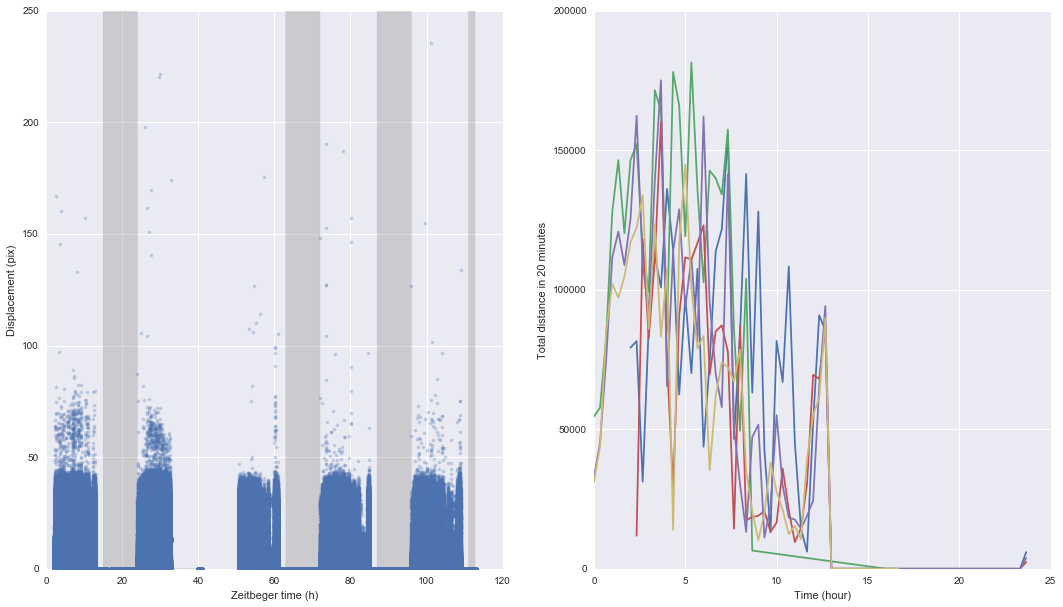

In [8]:
process_animal('2CW100', '9/25/2016', ndays=5, save=True)

2CW305/0714/
2CW305/0715/
2CW305/0716/
2CW305/0717/


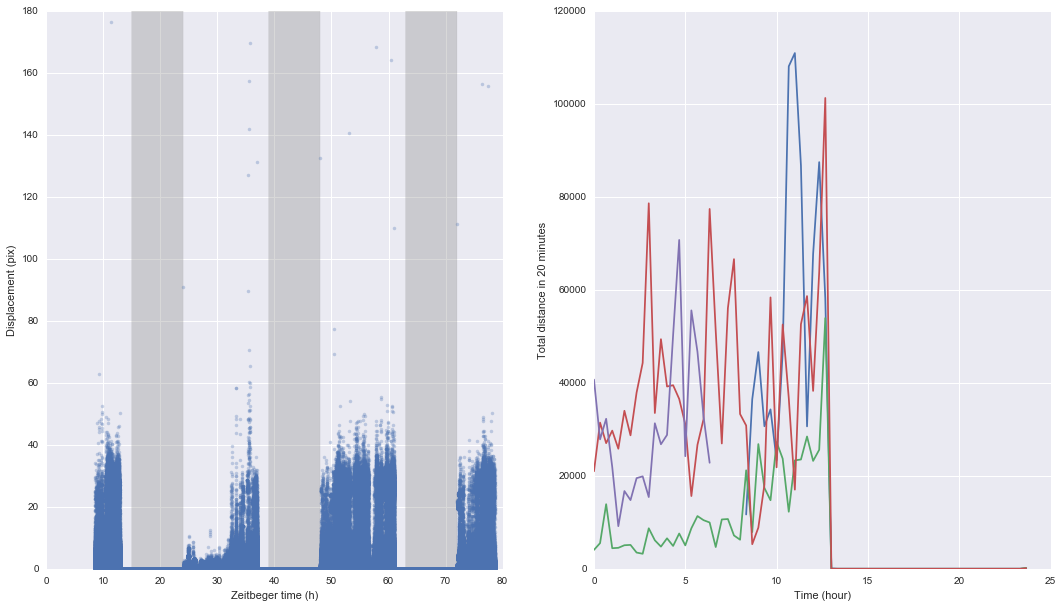

In [9]:
process_animal('2CW305', '7/14/2016', ndays=4, save=True, parse_filename=True)

2CW318/0628/
2CW318/0629/
2CW318/0630/
2CW318/0701/


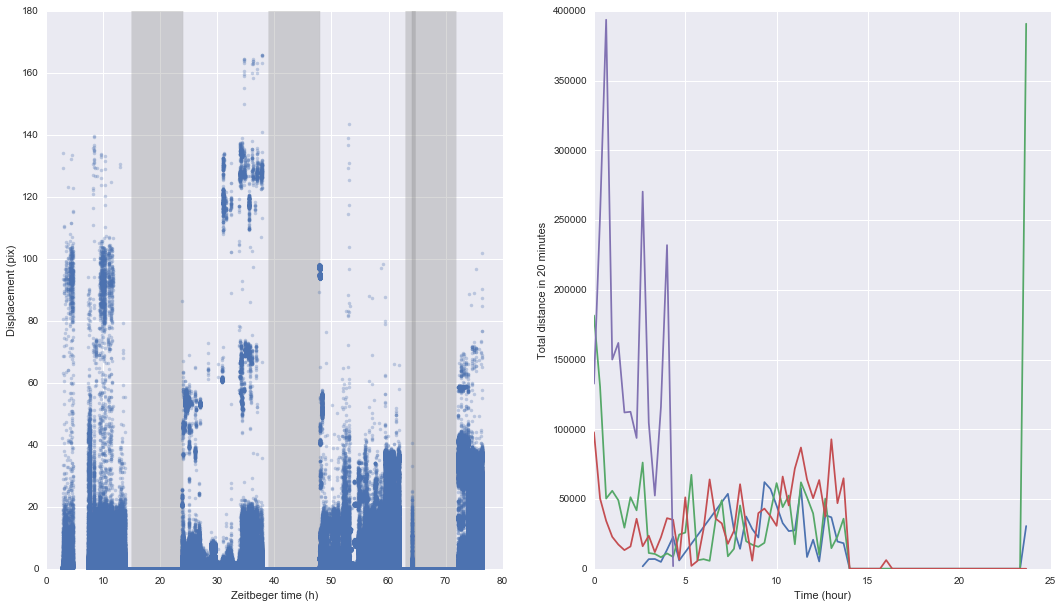

In [10]:
process_animal('2CW318', '6/28/2016', ndays=4, save=True, parse_filename=True, find_cumtime=False)

LB21/0701/
LB21/0702/
LB21/0703/
LB21/0704/
LB21/0705/


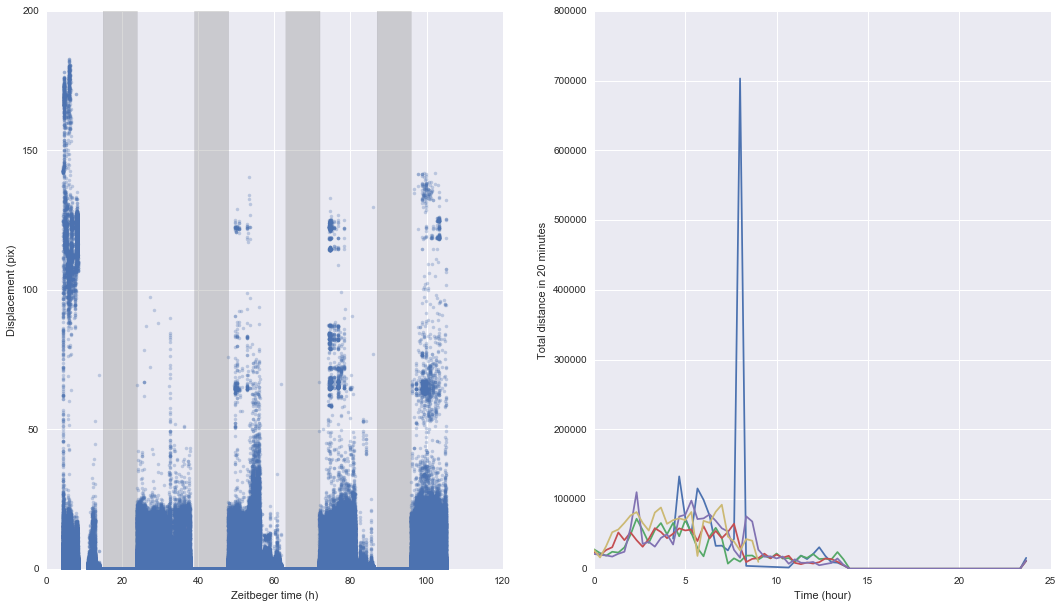

In [11]:
process_animal('LB21', '7/1/2016', ndays=5, save=True, parse_filename=True)

2CW312/0709/
2CW312/0710/
2CW312/0711/
2CW312/0712/
2CW312/0713/
2CW312/0714/


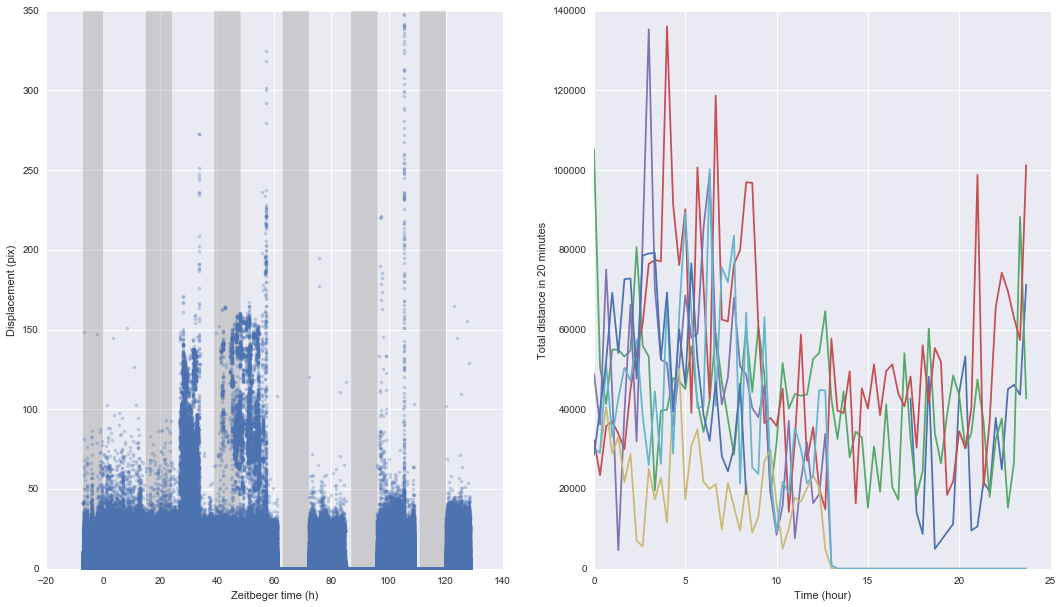

In [12]:
process_animal('2CW312', '7/9/2016', ndays=6, save=True, parse_filename=True)

LB15/0711/
LB15/0712/
LB15/0713/
LB15/0714/


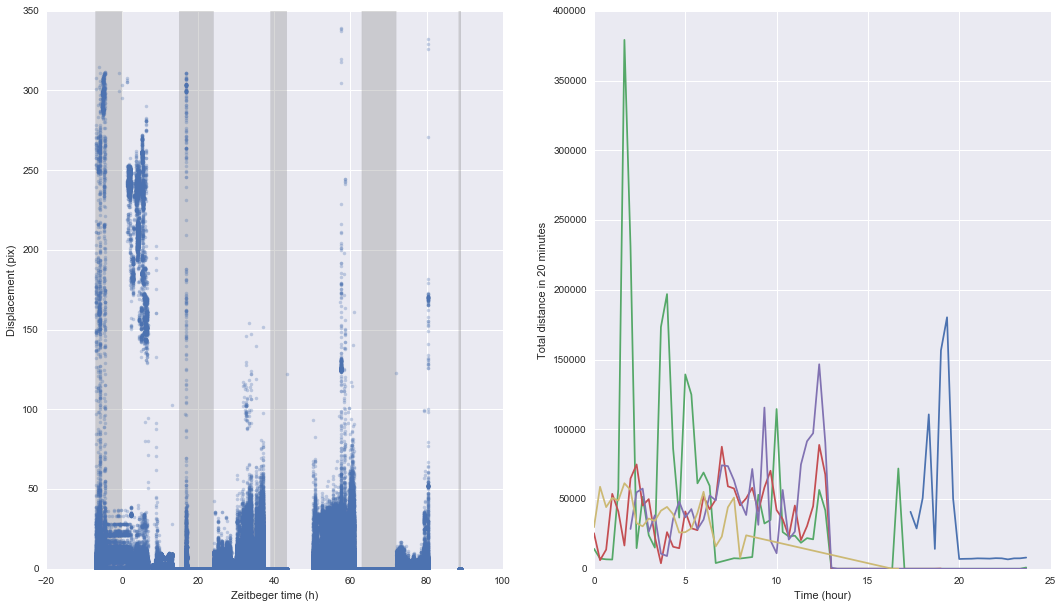

In [5]:
act = process_animal('LB15', '7/11/2016', ndays=4, save=False)

2CW306/0719/
2CW306/0720/
2CW306/0721/
2CW306/0722/


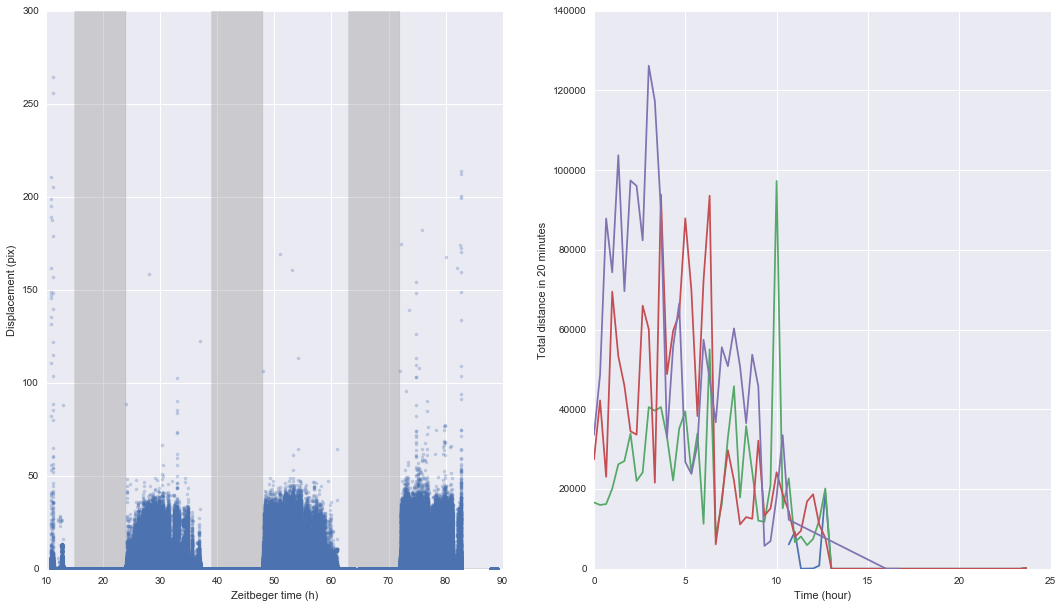

In [14]:
process_animal('2CW306', '7/19/2016', ndays=4, save=True)

2CW308/0714/
2CW308/0715/
2CW308/0716/
2CW308/0717/


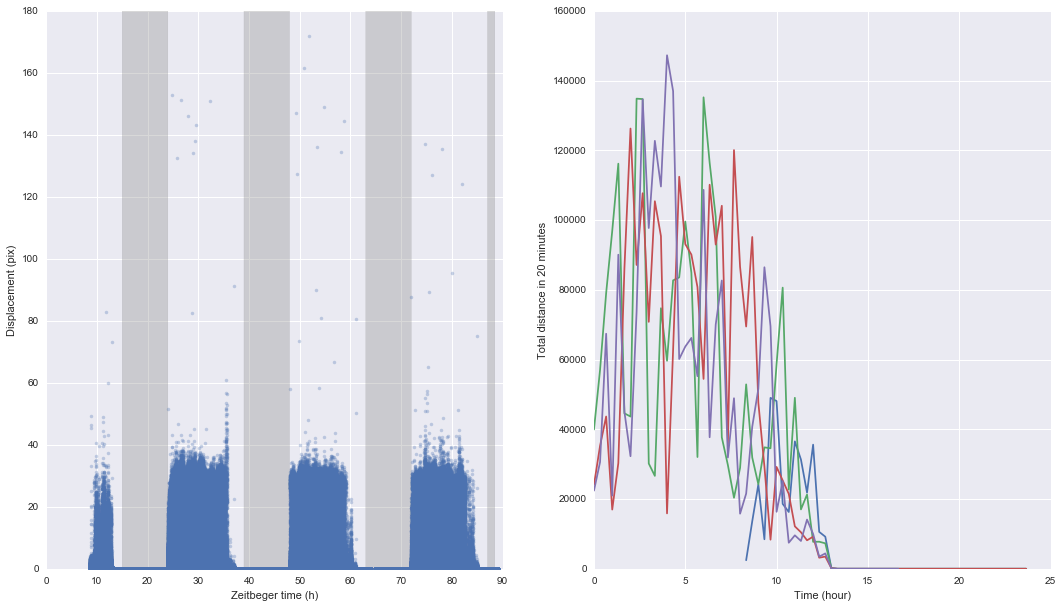

In [15]:
process_animal('2CW308', '7/14/2016', ndays=4, save=True)

LB06/0718/
LB06/0719/
LB06/0720/


IOError: File exists, cannot overwrite...

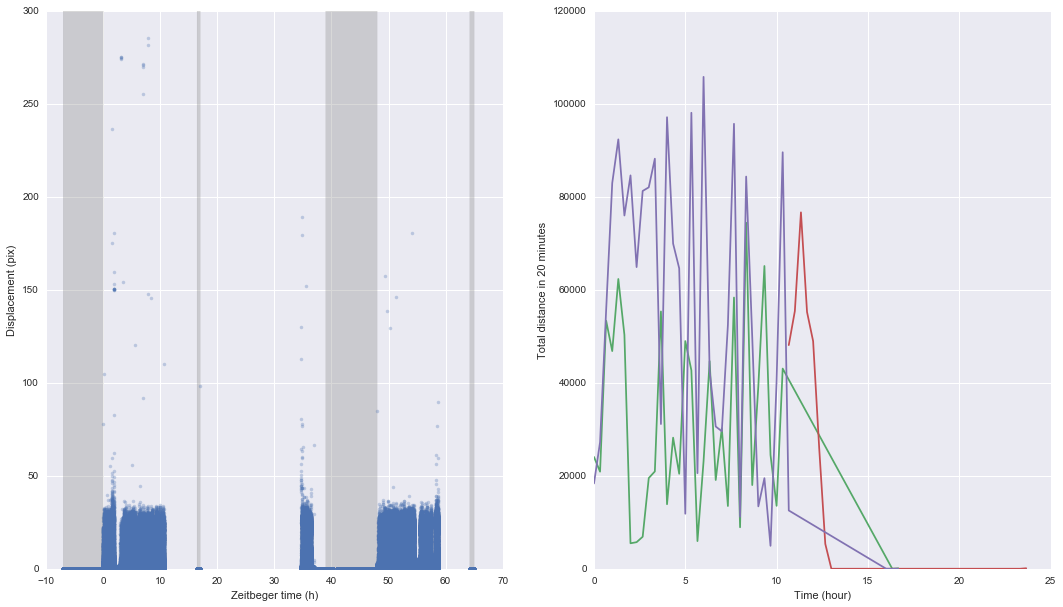

In [6]:
process_animal('LB06', '7/18/2016', ndays=3, save=True)

Or130/0722/
Or130/0723/
Or130/0724/
Or130/0725/
Or130/0726/
Or130/0727/
Or130/0728/


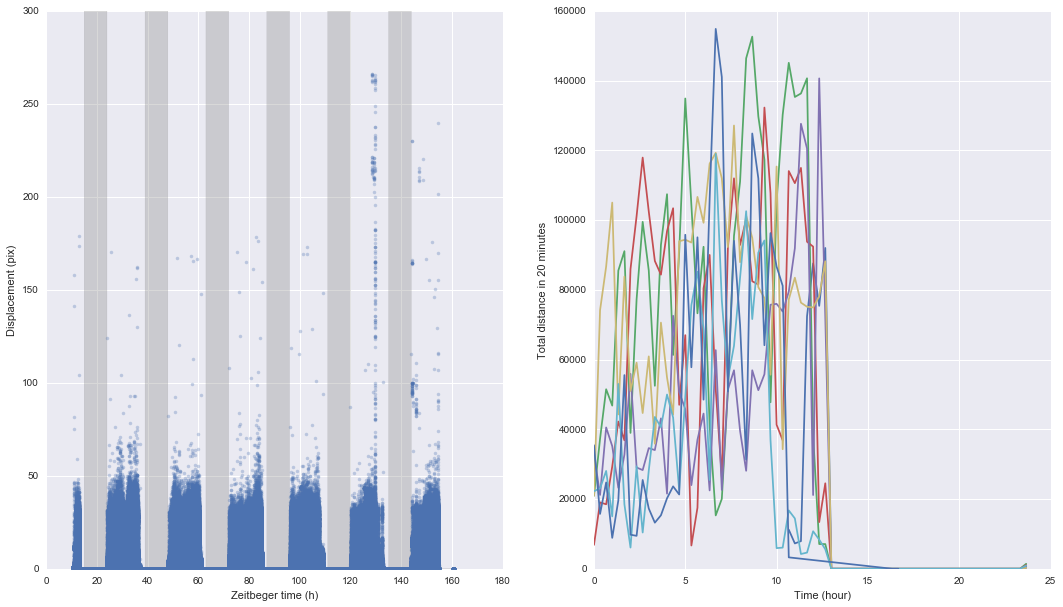

In [17]:
process_animal('Or130', '7/22/2016', ndays=7, save=True)

Or114/0726/
Or114/0727/
Or114/0728/
Or114/0729/
Or114/0730/
Or114/0731/
     Directory does not exist
Or114/0801/
Or114/0802/
Or114/0803/


,Interval,x,y,Area,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
17438,0.12467,160.5,90.5,57600,0,0,0.003,26,7,2016,2016-07-26 00:00:00.003,False,0.0,-6.999999
17439,0.13351,160.5,90.5,57600,0,0,0.137,26,7,2016,2016-07-26 00:00:00.137,False,0.0,-6.999962
17440,0.14209,160.5,90.5,57600,0,0,0.279,26,7,2016,2016-07-26 00:00:00.279,False,0.0,-6.999923
17441,0.12982,160.5,90.5,57600,0,0,0.409,26,7,2016,2016-07-26 00:00:00.409,False,0.0,-6.999886
17442,0.11206,160.5,90.5,57600,0,0,0.521,26,7,2016,2016-07-26 00:00:00.521,False,0.0,-6.999855
17443,0.15132,160.5,90.5,57600,0,0,0.672,26,7,2016,2016-07-26 00:00:00.672,False,0.0,-6.999813
17444,0.13333,160.5,90.5,57600,0,0,0.807,26,7,2016,2016-07-26 00:00:00.807,False,0.0,-6.999776
17445,0.11360,160.5,90.5,57600,0,0,0.920,26,7,2016,2016-07-26 00:00:00.920,False,0.0,-6.999744
17446,0.15946,160.5,90.5,57600,0,0,1.080,26,7,2016,2016-07-26 00:00:01.080,False,0.0,-6.999700
17447,0.11245,160.5,90.5,57600,0,0,1.192,26,7,2016,2016-07-26 00:00:01.192,False,0.0,-6.999669


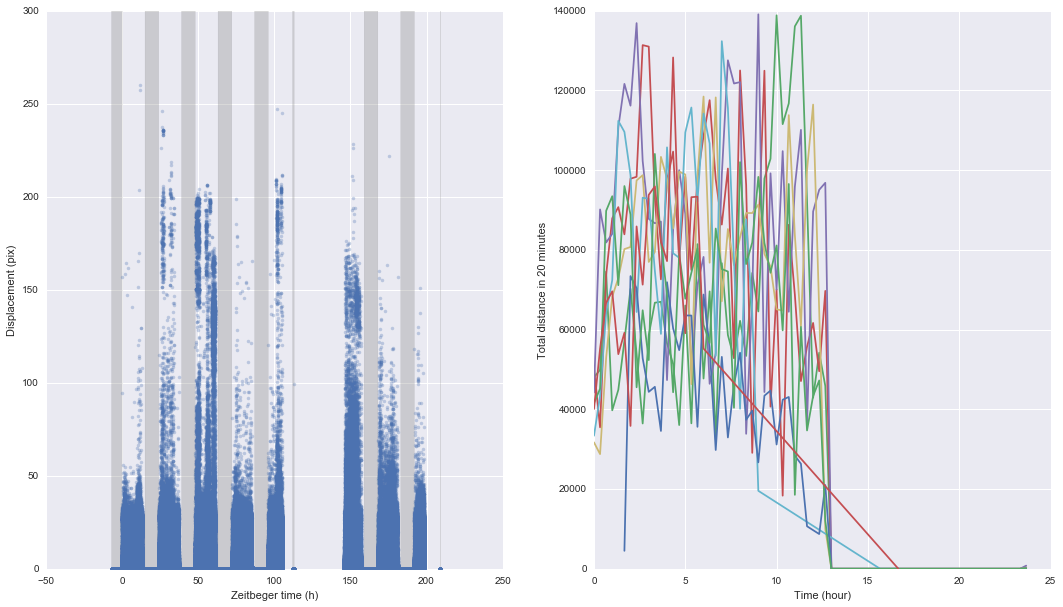

In [7]:
process_animal('Or114', '7/26/2016', ndays=9, save=False)

2CW317/0720/
2CW317/0721/
2CW317/0722/
2CW317/0723/
2CW317/0724/
2CW317/0725/


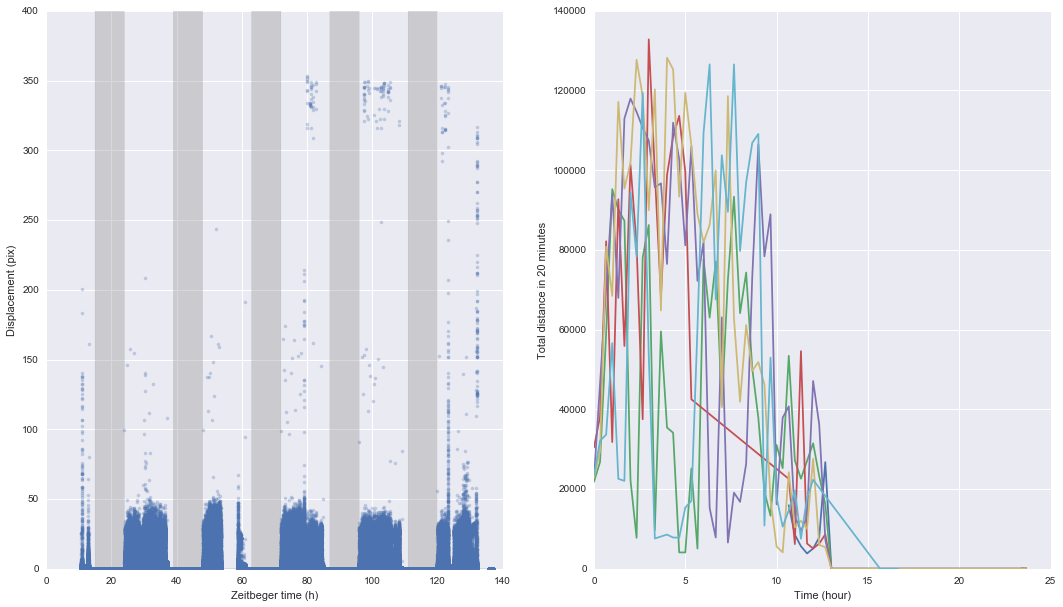

In [19]:
process_animal('2CW317', '7/20/2016', ndays=6, save=True)

Z1Pi229/0803/
Z1Pi229/0804/
Z1Pi229/0805/
Z1Pi229/0806/
Z1Pi229/0807/
Z1Pi229/0808/
Z1Pi229/0809/
Z1Pi229/0810/
Z1Pi229/0811/
Z1Pi229/0812/
Z1Pi229/0813/
Z1Pi229/0814/
Z1Pi229/0815/
Z1Pi229/0816/
Z1Pi229/0817/


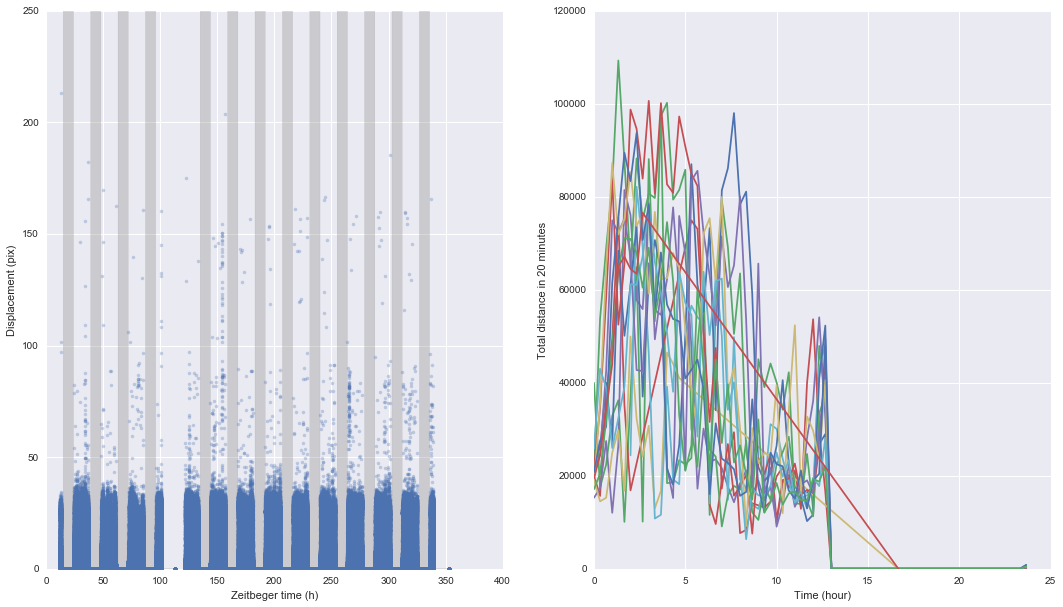

In [20]:
process_animal('Z1Pi229', '8/3/2016', ndays=15, save=True)

Z1Pi230/0803/
Z1Pi230/0804/
Z1Pi230/0805/
Z1Pi230/0806/
Z1Pi230/0807/
     Directory does not exist
Z1Pi230/0808/
Z1Pi230/0809/
Z1Pi230/0810/
Z1Pi230/0811/
Z1Pi230/0812/
Z1Pi230/0813/
Z1Pi230/0814/
Z1Pi230/0815/


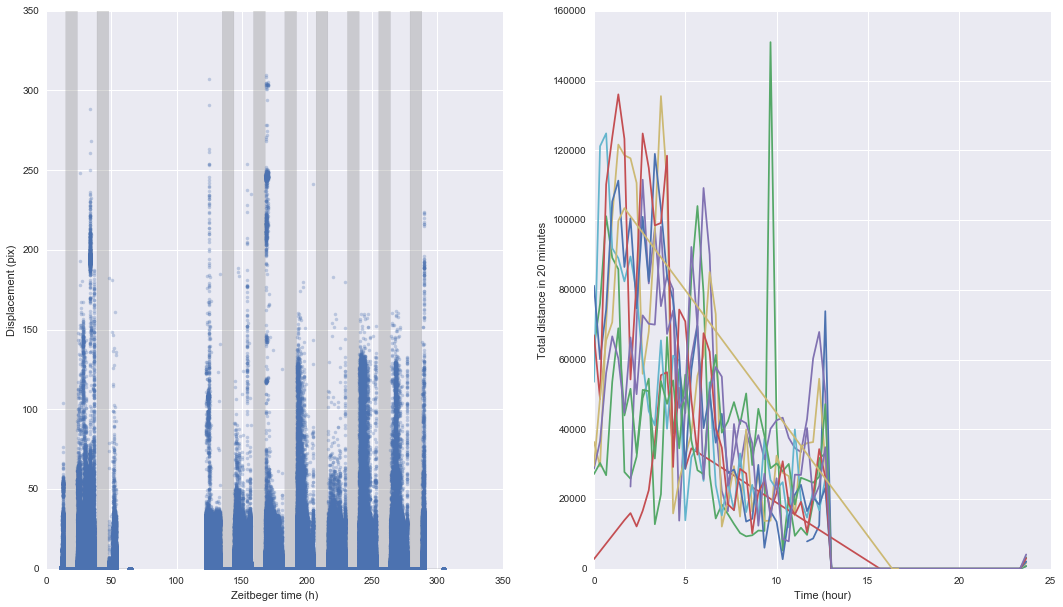

In [21]:
process_animal('Z1Pi230', '8/3/2016', ndays=13, save=True)

LB2/0919/
LB2/0920/
LB2/0921/
LB2/0922/
LB2/0923/
LB2/0924/


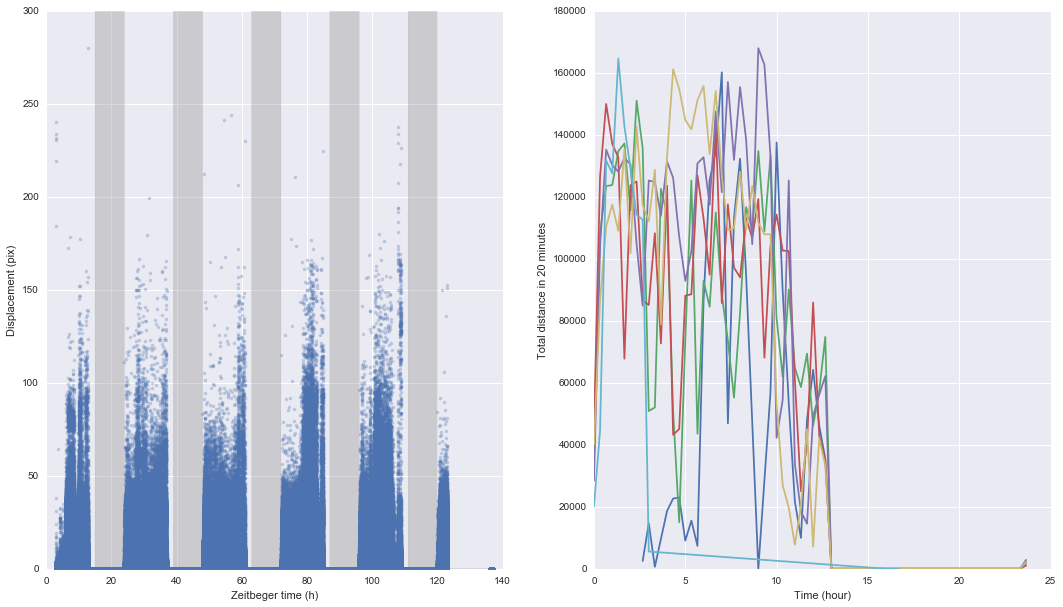

In [22]:
process_animal('LB2', '9/19/2016', ndays=6, save=True)

LB11/0822/
LB11/0823/
LB11/0824/
LB11/0825/
LB11/0826/
LB11/0827/
LB11/0828/
LB11/0829/
LB11/0830/


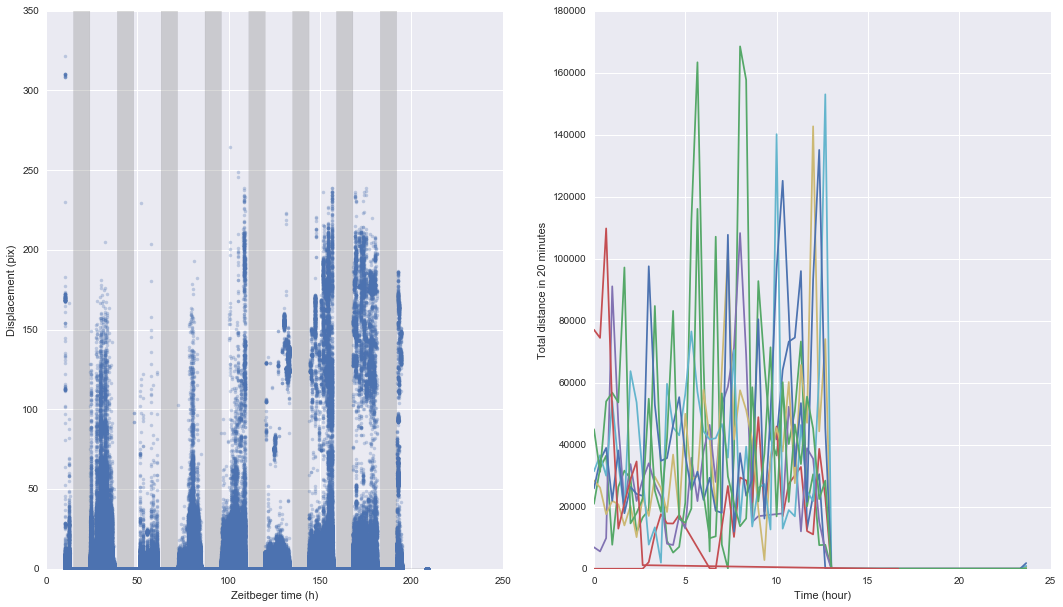

In [23]:
process_animal('LB11', '8/22/2016', ndays=9, save=True)

Or128/0822/
Or128/0823/
Or128/0824/
Or128/0825/
Or128/0826/
Or128/0827/
Or128/0828/
Or128/0829/
Or128/0830/


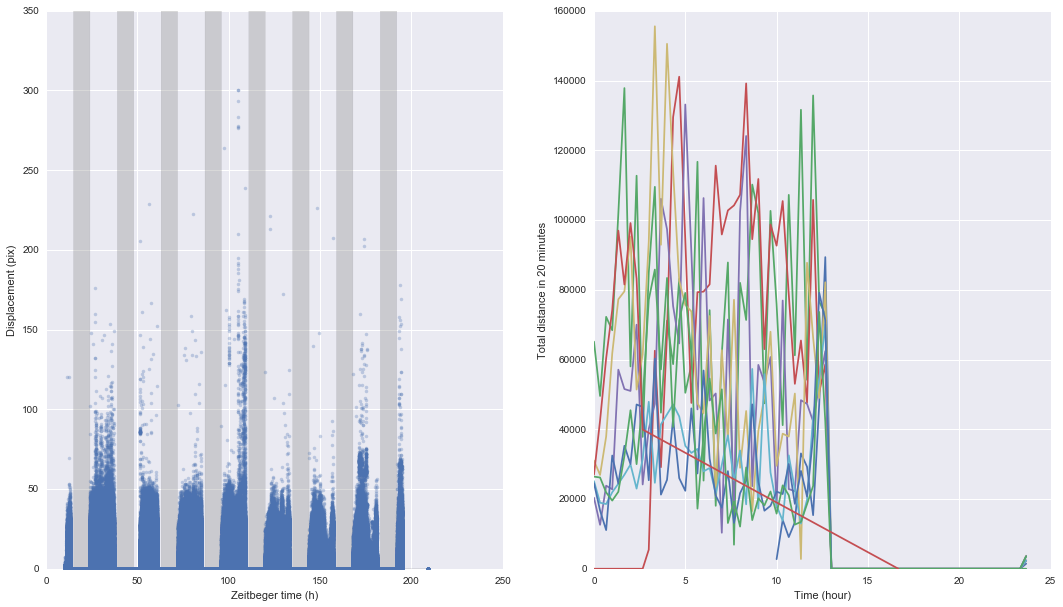

In [24]:
process_animal('Or128', '8/22/2016', ndays=9, save=True)